# DEPENDENCIES 

In [2]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

# SUMMARY


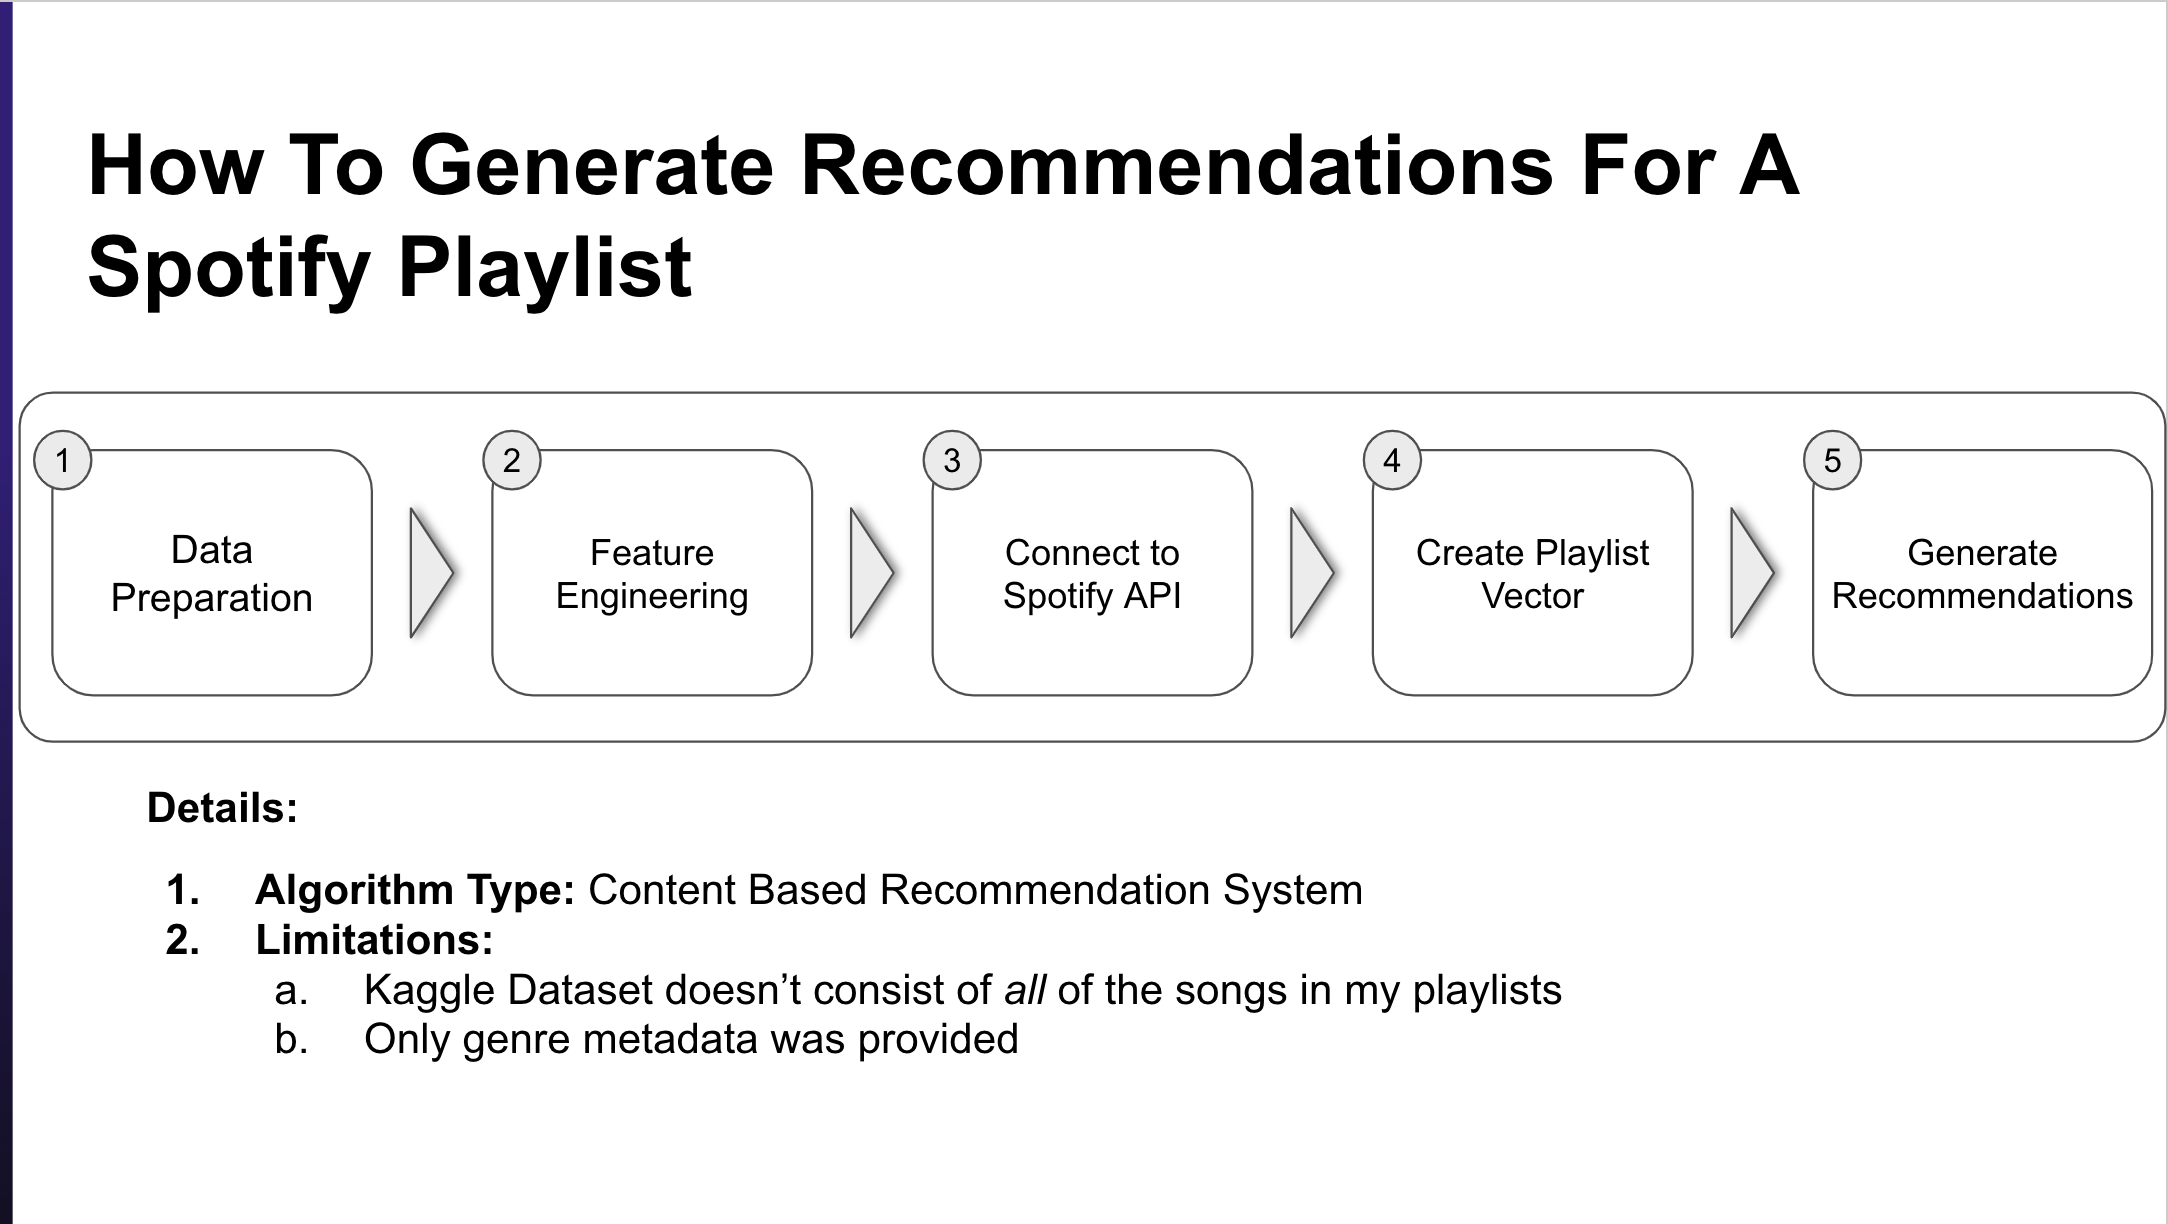

In [4]:
from IPython.display import Image
Image("C:/Users/ishku/OneDrive/Desktop/projects/recommender system/statics/summary.png")

# 1. Data Preparation


In [3]:
spotify_df = pd.read_csv("./datasets/data.csv")

In [5]:
spotify_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [7]:
data_w_genre = pd.read_csv("./datasets/data_w_genres.csv")

In [8]:
data_w_genre.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,33.076923,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.285714,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.444444,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.605444,0.437333,232428.111111,0.429333,0.037534,0.216111,-11.447222,0.086000,120.329667,0.458667,42.555556,11,1,9,[]


In [9]:
data_w_genre.dtypes

artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
genres               object
dtype: object

In [10]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [11]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [14]:
type(data_w_genre['genres_upd'].values[0])

list

Step 1. Similar to before, we will need to extract the artists from the string list.

In [15]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))

In [16]:
spotify_df['artists'].values[0]

"['Mamie Smith']"

In [18]:
type(spotify_df['artists_upd_v1'].values[0])

list

In [19]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1
1,0.643,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.950,1920,[]
34,0.021,"[""The Swingin' Bachelors""]",0.559,288293,0.830,0,0bq1lNI8OPhdRQYZZSSnQk,0.146000,11,0.1870,-7.876,0,Voodoo Doll,0,1920-02-29,0.0546,107.912,0.352,1920,[]
36,0.790,"[""The Swingin' Bachelors""]",0.745,261013,0.791,0,0e0zhCKclqwgJgA7Tjg2ca,0.000000,7,0.1020,-8.584,1,Penticton Kitty,0,1920-02-29,0.0595,120.169,0.658,1920,[]
46,0.147,"[""The Swingin' Bachelors""]",0.603,235547,0.719,0,0xKe1lGyWBuk3lx3JIUUUx,0.000000,0,0.1110,-5.464,0,Cloud 9,0,1920-02-29,0.0271,92.010,0.697,1920,[]
47,0.367,"[""The Swingin' Bachelors""]",0.716,264240,0.836,0,11rj3RWlVnnxW0EL7jwN8R,0.000006,9,0.1910,-6.099,1,Big Jim and the Twins,0,1920-02-29,0.0451,105.986,0.635,1920,[]


In [20]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [26]:
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+" " + row['name'],axis = 1)

In [22]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [27]:
spotify_df[spotify_df['name']=='Hello']

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
138035,0.0237,['Poe'],0.750,271680,0.735,0,1UT2yVLkkJyoLVtGbPgHpi,0.124000,9,0.1290,...,34,1995-09-14,0.1090,92.902,0.5180,1995,[Poe],[],[Poe],Poe Hello
71560,0.0136,['Oasis'],0.318,203187,0.952,0,4qYlBtzkmby4r1N7etPnUv,0.015200,9,0.1670,...,55,1995-10-02,0.0940,132.191,0.0537,1995,[Oasis],[],[Oasis],Oasis Hello
157339,0.0339,['OMFG'],0.844,226308,0.864,0,6BAnxKyld909yo6Pk1DO3r,0.216000,7,0.3860,...,64,2014-12-03,0.0348,104.997,0.7960,2014,[OMFG],[],[OMFG],OMFG Hello
12512,0.4140,['Lionel Richie'],0.487,251107,0.246,0,0mHyWYXmmCB9iQyK18m3FQ,0.000000,9,0.0983,...,57,1983-01-01,0.0376,61.084,0.0562,1983,[Lionel Richie],[],[Lionel Richie],Lionel Richie Hello
51034,0.5160,['Lionel Richie'],0.563,248573,0.262,0,1b16zIZIdL2LIMfDiANwIk,0.000000,9,0.1940,...,42,1983,0.0333,124.206,0.0626,1983,[Lionel Richie],[],[Lionel Richie],Lionel Richie Hello
76768,0.4650,"['KAROL G', 'Ozuna']",0.802,194933,0.839,0,2776pPgCa5KrLVUqNBtjfJ,0.000052,7,0.1170,...,0,2021-01-22,0.0592,94.997,0.8610,2021,"[KAROL G, Ozuna]",[],"[KAROL G, Ozuna]",KAROL G Hello
76774,0.4650,"['KAROL G', 'Ozuna']",0.802,194933,0.839,0,2ljhKzXJAPBmRN0QIkxKHG,0.000052,7,0.1170,...,0,2021-01-22,0.0592,94.997,0.8610,2021,"[KAROL G, Ozuna]",[],"[KAROL G, Ozuna]",KAROL G Hello
76780,0.4650,"['KAROL G', 'Ozuna']",0.802,194933,0.839,0,36YVsPZh2byKbodjUDyjTG,0.000052,7,0.1170,...,0,2021-01-22,0.0592,94.997,0.8610,2021,"[KAROL G, Ozuna]",[],"[KAROL G, Ozuna]",KAROL G Hello
76782,0.4650,"['KAROL G', 'Ozuna']",0.802,194933,0.839,0,371SS9OeuFXXUvF3SECivH,0.000052,7,0.1170,...,0,2021-01-22,0.0592,94.997,0.8610,2021,"[KAROL G, Ozuna]",[],"[KAROL G, Ozuna]",KAROL G Hello
93886,0.4650,"['KAROL G', 'Ozuna']",0.802,194933,0.839,0,4CRlkAw8jAbVdXCjySXmFl,0.000052,7,0.1170,...,0,2021-01-22,0.0592,94.997,0.8610,2021,"[KAROL G, Ozuna]",[],"[KAROL G, Ozuna]",KAROL G Hello


In [28]:
spotify_df.drop_duplicates('artists_song',inplace = True)

In [29]:
spotify_df[spotify_df['name']=='Hello']

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
138035,0.0237,['Poe'],0.750,271680,0.735,0,1UT2yVLkkJyoLVtGbPgHpi,0.124000,9,0.1290,...,34,1995-09-14,0.1090,92.902,0.5180,1995,[Poe],[],[Poe],Poe Hello
71560,0.0136,['Oasis'],0.318,203187,0.952,0,4qYlBtzkmby4r1N7etPnUv,0.015200,9,0.1670,...,55,1995-10-02,0.0940,132.191,0.0537,1995,[Oasis],[],[Oasis],Oasis Hello
157339,0.0339,['OMFG'],0.844,226308,0.864,0,6BAnxKyld909yo6Pk1DO3r,0.216000,7,0.3860,...,64,2014-12-03,0.0348,104.997,0.7960,2014,[OMFG],[],[OMFG],OMFG Hello
12512,0.4140,['Lionel Richie'],0.487,251107,0.246,0,0mHyWYXmmCB9iQyK18m3FQ,0.000000,9,0.0983,...,57,1983-01-01,0.0376,61.084,0.0562,1983,[Lionel Richie],[],[Lionel Richie],Lionel Richie Hello
76768,0.4650,"['KAROL G', 'Ozuna']",0.802,194933,0.839,0,2776pPgCa5KrLVUqNBtjfJ,0.000052,7,0.1170,...,0,2021-01-22,0.0592,94.997,0.8610,2021,"[KAROL G, Ozuna]",[],"[KAROL G, Ozuna]",KAROL G Hello
92762,0.0771,['J. Cole'],0.598,219173,0.700,1,30Chv2SmIry70YwtmtaKnj,0.000011,9,0.1060,...,58,2014-12-09,0.2200,159.899,0.3290,2014,[J. Cole],[],[J. Cole],J. Cole Hello
54384,0.1550,"['Ice Cube', 'Dr. Dre', 'MC Ren']",0.903,232533,0.610,1,60uesDF4UyLUs61FgiDkdp,0.000000,10,0.3890,...,58,2000-02-29,0.3390,91.460,0.6270,2000,"[Ice Cube, Dr. Dre, MC Ren]",[],"[Ice Cube, Dr. Dre, MC Ren]",Ice Cube Hello
73174,0.9120,['Evanescence'],0.416,220360,0.178,0,0aYUqsvZG7bAslrUkd9Z0g,0.000138,11,0.3420,...,58,2003-03-04,0.0310,139.969,0.0699,2003,[Evanescence],[],[Evanescence],Evanescence Hello
38280,0.3300,['Adele'],0.578,295502,0.430,0,62PaSfnXSMyLshYJrlTuL3,0.000000,5,0.0854,...,71,2015-11-20,0.0305,78.991,0.2880,2015,[Adele],[],[Adele],Adele Hello


In [30]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [35]:
artists_exploded

,artists_upd,id
167865,조정현,2ghebdwe2pNXT4eL34T7pW
173888,김효근,6ra76urfo3pTD050opXTZS
173888,Quinever 퀸에버,6ra76urfo3pTD050opXTZS
166711,김수철,4FG1uHQAVPsYiXIn3tcGRs
75703,龔詩嘉,2w5L5kQVkSRdduNewYPDA5
...,...,...
105296,"Cru"", ""Michel",3hoiinUc5VA9xUEJID7R8V
71705,"Choir"",",7GaUNnAdIMXrvYG7673QIK
139006,"4-Tay"",",0CHKRuAjf8LvCL6SxCnq7V
154041,"4-Tay"",",78859Af0fmA9VTlgnOHTAP


In [33]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [40]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['artists'] =='Adele']

,artists_upd,id,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres,genres_upd
173477,Adele,6FZjUIfR6vEEg1bT9elJlf,Adele,0.43887,0.564595,249647.52381,0.500643,0.002624,0.130888,-7.034881,0.052583,121.253167,0.373131,60.47619,0.0,1.0,84.0,"['british soul', 'pop', 'uk pop']","[british_soul, pop, uk_pop]"
208568,Adele,7GgWAITsYJaRM3r50rfh5w,Adele,0.43887,0.564595,249647.52381,0.500643,0.002624,0.130888,-7.034881,0.052583,121.253167,0.373131,60.47619,0.0,1.0,84.0,"['british soul', 'pop', 'uk pop']","[british_soul, pop, uk_pop]"
208569,Adele,4jL6WWKFDqCOPo2hC3VhSS,Adele,0.43887,0.564595,249647.52381,0.500643,0.002624,0.130888,-7.034881,0.052583,121.253167,0.373131,60.47619,0.0,1.0,84.0,"['british soul', 'pop', 'uk pop']","[british_soul, pop, uk_pop]"
208570,Adele,4oy98QoABnGKpvapDkI525,Adele,0.43887,0.564595,249647.52381,0.500643,0.002624,0.130888,-7.034881,0.052583,121.253167,0.373131,60.47619,0.0,1.0,84.0,"['british soul', 'pop', 'uk pop']","[british_soul, pop, uk_pop]"
208571,Adele,08YJEcxGtYXwCGqXMZDiyQ,Adele,0.43887,0.564595,249647.52381,0.500643,0.002624,0.130888,-7.034881,0.052583,121.253167,0.373131,60.47619,0.0,1.0,84.0,"['british soul', 'pop', 'uk pop']","[british_soul, pop, uk_pop]"
208572,Adele,1zwMYTA5nlNjZxYrvBB2pV,Adele,0.43887,0.564595,249647.52381,0.500643,0.002624,0.130888,-7.034881,0.052583,121.253167,0.373131,60.47619,0.0,1.0,84.0,"['british soul', 'pop', 'uk pop']","[british_soul, pop, uk_pop]"
208573,Adele,6VObnIkLVruX4UVyxWhlqm,Adele,0.43887,0.564595,249647.52381,0.500643,0.002624,0.130888,-7.034881,0.052583,121.253167,0.373131,60.47619,0.0,1.0,84.0,"['british soul', 'pop', 'uk pop']","[british_soul, pop, uk_pop]"
208574,Adele,73CMRj62VK8nUS4ezD2wvi,Adele,0.43887,0.564595,249647.52381,0.500643,0.002624,0.130888,-7.034881,0.052583,121.253167,0.373131,60.47619,0.0,1.0,84.0,"['british soul', 'pop', 'uk pop']","[british_soul, pop, uk_pop]"
208575,Adele,0t7fVeEJxO2Xi4H2K5Svc9,Adele,0.43887,0.564595,249647.52381,0.500643,0.002624,0.130888,-7.034881,0.052583,121.253167,0.373131,60.47619,0.0,1.0,84.0,"['british soul', 'pop', 'uk pop']","[british_soul, pop, uk_pop]"
208576,Adele,2A73XBDBQgmdXO8VsXPWIs,Adele,0.43887,0.564595,249647.52381,0.500643,0.002624,0.130888,-7.034881,0.052583,121.253167,0.373131,60.47619,0.0,1.0,84.0,"['british soul', 'pop', 'uk pop']","[british_soul, pop, uk_pop]"


In [41]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [42]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [44]:
artists_genres_consolidated

,id,genres_upd,consolidates_genre_lists
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_romantic, new_wav...","[permanent_wave, dance_rock, rock, new_wave, n..."
1,000Npgk5e2SgwGaIsN3ztv,"[[classic_bollywood, classic_pakistani_pop, fi...","[filmi, classic_pakistani_pop, indian_folk, su..."
2,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, ragtime, stride]]","[boogie-woogie, stride, ragtime, piano_blues]"
3,000jBcNljWTnyjB4YO7ojf,[[]],[]
4,000mGrJNc2GAgQdMESdgEc,"[[classical, late_romantic_era], [historic_orc...","[classical, historic_orchestral_performance, o..."
...,...,...,...
139532,7zxiwcqLQyWcLdThrsYklu,"[[adult_standards, bebop, big_band, cool_jazz,...","[swing, cool_jazz, big_band, adult_standards, ..."
139533,7zxmX2NsbCBNlqHBmkyWxs,"[[bebop, contemporary_post-bop, cool_jazz, har...","[soul_jazz, hard_bop, contemporary_post-bop, c..."
139534,7zzbPkvxJ6iANIxcSz60rm,"[[adult_standards, cool_jazz, jazz, lounge, sw...","[swing, cool_jazz, vocal_jazz, adult_standards..."
139535,7zzbfi8fvHe6hm342GcNYl,"[[blues_rock, country_rock, folk_rock, jam_ban...","[country_rock, roots_rock, blues_rock, folk_ro..."


In [45]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

In [47]:
spotify_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,...,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists
0,0.568,['조정현'],0.447,237688,0.215,0,2ghebdwe2pNXT4eL34T7pW,0.000001,10,0.0649,...,1989-06-15,0.0272,71.979,0.1770,1989,[조정현],[],[조정현],조정현 그아픔까지사랑한거야,NaN
1,0.939,"['김효근', 'Quinever 퀸에버']",0.174,341821,0.321,0,6ra76urfo3pTD050opXTZS,0.756000,3,0.6950,...,2019-10-18,0.0422,138.300,0.0554,2019,"[김효근, Quinever 퀸에버]",[],"[김효근, Quinever 퀸에버]",김효근 Promise of Thousand Years 천 년의 약속,NaN
2,0.509,['김수철'],0.456,189245,0.321,0,4FG1uHQAVPsYiXIn3tcGRs,0.000001,4,0.1560,...,1983-08-15,0.0314,79.114,0.2100,1983,[김수철],[],[김수철],김수철 못다핀 꽃한송이,NaN
3,0.134,['龔詩嘉'],0.450,184120,0.782,0,2w5L5kQVkSRdduNewYPDA5,0.000000,0,0.0632,...,2015-07-31,0.0306,87.980,0.4750,2015,[龔詩嘉],[],[龔詩嘉],龔詩嘉 My Island Home,NaN
4,0.381,['黑豹'],0.353,316160,0.686,0,3KIuCzckjdeeVuswPo20mC,0.000000,11,0.0568,...,1992-12-22,0.0395,200.341,0.3520,1992,[黑豹],[],[黑豹],黑豹 DON'T BREAK MY HEART,"[chinese_indie_rock, chinese_indie]"


# 2. FEATURE ENGINEERING